# Data folders organization

In [1]:
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
import attr

In [2]:
@attr.s(auto_attribs=True)
class DirManagement:
    project_dir: str
    labels_dict: dict 
    
    @property
    def labels_list(self):
        return list(self.labels_dict.keys())
    
    @property
    def data_dir(self):
        return Path(self.project_dir) / "figures"
    
    @property
    def raw_data_dir(self):
        return Path(self.project_dir) / "raw_figures"
    
    @property
    def all_filenames(self):
        all_filenames = []
        for folder in self.raw_data_dir.iterdir():
            for image in folder.glob("*.png"):
                all_filenames.append(image)
        return all_filenames
                
    def create_datasets(self, test_size, val_size):
        """
        split all filenames in train, validation and test datasets
        """
        _, test_filenames = train_test_split(self.all_filenames, test_size=test_size, random_state=42, shuffle=True)
        train_filenames, val_filenames = train_test_split(_, test_size=val_size/(1-test_size), random_state=42, shuffle=True)
        return train_filenames, val_filenames, test_filenames
    
    def _create_new_dirs(self):
        """
        create new organized directories
        """
        if self.data_dir.exists():
            shutil.rmtree(self.data_dir)
        Path.mkdir(self.data_dir)
        datasets = ["train", "val", "test"]
        for dataset in datasets:
            dataset_dir = self.data_dir / dataset
            Path.mkdir(dataset_dir)
            for label in self.labels_list:
                Path.mkdir(dataset_dir / label)
    
    def write_data(self, train_filenames, val_filenames, test_filenames):
        """
        copy the images from raw dir to the new directory
        """
        self._create_new_dirs()
        for dataset in [("train", train_filenames), ("val", val_filenames),("test", test_filenames)]:
            for filename in dataset[1]:
                if filename.stem.split("_")[-1] == self.labels_dict["normal"]:
                    shutil.copy(filename, self.data_dir / dataset[0] / "normal" / f"{filename.stem}.png")
                elif len(filename.stem.split("_")) == 3:
                    shutil.copy(filename, self.data_dir / dataset[0] / "abnormal" / f"{filename.stem}.png")
    

In [3]:
PROJ_DIR_STR = "/mnt/Media/bernardo/Documents/PhD/Courses/Deep Structured Learning/Project"
LABELS_DICT = {
    "abnormal": [], 
    "normal": "N"
}
TEST_FRACTION = 0.1
VAL_FRACTION = 0.05

In [5]:
dir_prep = DirManagement(PROJ_DIR_STR, LABELS_DICT)
train, val, test = dir_prep.create_datasets(TEST_FRACTION, VAL_FRACTION)
dir_prep.write_data(train, val, test)

# Pytorch data loading - adapted from [transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
plt.ion()   # interactive mode

* All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
https://pytorch.org/docs/stable/torchvision/models.html
* Augmentation: maybe not necessary, random flips or rotations
* Image resizing: not sure... from a [medium](https://medium.com/@nina95dan/simple-image-classification-with-resnet-50-334366e7311a#:~:text=ResNet%2D50%20is%20a%20pre,applied%20to%20analyzing%20visual%20imagery.) post size has to be 224*224 --> transforms resize(224) not working as suppose I think

In [13]:
@attr.s(auto_attribs=True)
class DataPreparation:
    dirs: DirManagement
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)  
        
    @staticmethod
    def data_transformations():
        data_transforms = {
            'train': transforms.Compose([
        #         transforms.RandomResizedCrop(224),
        #         transforms.RandomHorizontalFlip(),
                transforms.Resize(224),
        #         transforms.CenterCrop((800, 200)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(224),
        #         transforms.CenterCrop(800),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(224),
        #         transforms.CenterCrop(800),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    
    def create_dataloaders(self):
        data_transforms = self.data_transformations()
        image_datasets = {x: datasets.ImageFolder(self.dirs.data_dir / x, data_transforms[x]) for x in ['train', 'val', 'test']}
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
        dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
        return dataloaders, dataset_sizes
    
    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated
    

In [14]:
DataPreparation(dir_prep).create_dataloaders()

({'train': <torch.utils.data.dataloader.DataLoader at 0x7f03b3cad250>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7f03b3cad150>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7f03b3cad910>},
 {'train': 1316, 'val': 75, 'test': 184})

In [107]:
inputs, classes = next(iter(dataloaders['train']))

In [108]:
out = torchvision.utils.make_grid(inputs)

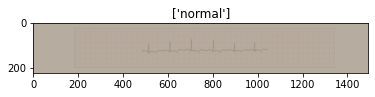

In [109]:
imshow(out, title=[class_names[x] for x in classes])